Course:
<br>https://codingcorner.org/unscented-transformation-explained-with-python</br>

### Import libraries 

In [10]:
import sys
import numpy as np
import pandas as pd
from scipy.linalg import expm
import scipy
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

np.set_printoptions(suppress=True)

### Introduction

#### Prediction step
First we follow the same approach as in unscented transformation using monte carlo
</br>
<img src="images/unscented_kalman_filter_prediction_step.png"  width = 800 height=400 />
</br>
There will be some changes as its Unscented Kalman filter implementation. As first we have to calculate sigma points.Its similar to unscented transformation. 
Only difference is we are calculating these points. 
</br>
<img src="images/unscented_kalman_filter_calculating_sigma_points.png"  width = 500 height=200 />
</br>
There is another difference as we weight each of these points.
</br>
<img src="images/unscented_kalman_filter_calculating_associated_weights.png"  width = 500 height=200 />
</br>
We propagate these points as in unscented transformation. 
</br>
<img src="images/unscented_kalman_filter_nonlin_fc_prop.png"  width = 400 height=100 />
</br>
After the propagation, there comes another difference. As contrast to unscented transformation, we will calculate weighted mean, using weights calculated before.
</br>
<img src="images/unscented_kalman_filter_augmenting_state_and_var.png"  width = 400 height=150 />
</br>
And there we go. We have all what we needed. To sum it up, there are all formular in one image. 
</br>
<img src="images/unscented_kalman_filter_equations_overview.png"  width = 800 height=800 />


#### Update step
First we follow the same approach as in Linear Kalman filter. We have to propagate points. 
</br>
<img src="images/unscented_kalman_filter_propagating_predicted_points.png"  width = 800 height=400 />
</br>
Then we calculate cross-correlation, or P as we did int KF, EKF, but this time for x and y. 
</br>
<img src="images/unscented_kalman_filter_cross_cor_calculation.png"  width = 600 height=150 />
</br>
Then we calculate kalman gain based on P. 
</br>
<img src="images/unscented_kalman_filter_kalman_gain.png"  width = 600 height=200 />
</br>
And lastly we update state and covariance. 
</br>
<img src="images/unscented_kalman_filter_state_and_cov_update.png"  width = 600 height=200 />

### Implementation
#### Joint state vector and covariance matrix 

In [23]:
def augment_vectors(x, v):
    return np.row_stack((x, v))

def augment_covariances(P, Q):
    prows, pcols = np.shape(P)[0], np.shape(P)[1]
    qrows, qcols = np.shape(Q)[0], np.shape(Q)[1]
    
    nrows = prows + qrows
    ncols = pcols + qcols
    
    Pa = np.zeros((nrows, ncols))
    Pa[0:prows, 0:pcols] = P
    Pa[prows:nrows, pcols:ncols] = Q
    
    return Pa

In [24]:

x = np.array([[1.], [2.]])
v = np.array([[3.], [4.]])

P = np.array([[1., 1.], [1., 1.]])
Q = np.array([[2., 2.], [2., 2.]])

xa = augment_vectors(x, v)
Pa = augment_covariances(P, Q)

print(xa)
print(Pa)

[[1.]
 [2.]
 [3.]
 [4.]]
[[1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]]


#### UKF

In [25]:
class UKF(object):
    def __init__(self, dim_x, dim_z, Q, R, kappa=0.0):
        
        '''
        UKF class constructor
        inputs:
            dim_x : state vector x dimension
            dim_z : measurement vector z dimension
        
        - step 1: setting dimensions
        - step 2: setting number of sigma points to be generated
        - step 3: setting scaling parameters
        - step 4: calculate scaling coefficient for selecting sigma points
        - step 5: calculate weights
        '''
                
        # setting dimensions
        self.dim_x = dim_x         # state dimension
        self.dim_z = dim_z         # measurement dimension
        self.dim_v = np.shape(Q)[0]
        self.dim_n = np.shape(R)[0]
        self.dim_a = self.dim_x + self.dim_v + self.dim_n # assuming noise dimension is same as x dimension
        
        # setting number of sigma points to be generated
        self.n_sigma = (2 * self.dim_a) + 1
        
        # setting scaling parameters
        self.kappa = 3 - self.dim_a #kappa
        self.alpha = 0.001
        self.beta = 2.0

        alpha_2 = self.alpha**2
        self.lambda_ = alpha_2 * (self.dim_a + self.kappa) - self.dim_a
        
        # setting scale coefficient for selecting sigma points
        # self.sigma_scale = np.sqrt(self.dim_a + self.lambda_)
        self.sigma_scale = np.sqrt(self.dim_a + self.kappa)
        
        # calculate unscented weights
        # self.W0m = self.W0c = self.lambda_ / (self.dim_a + self.lambda_)
        # self.W0c = self.W0c + (1.0 - alpha_2 + self.beta)
        # self.Wi = 0.5 / (self.dim_a + self.lambda_)
        
        self.W0 = self.kappa / (self.dim_a + self.kappa)
        self.Wi = 0.5 / (self.dim_a + self.kappa)
        
        # initializing augmented state x_a and augmented covariance P_a
        self.x_a = np.zeros((self.dim_a, ))
        self.P_a = np.zeros((self.dim_a, self.dim_a))
        
        self.idx1, self.idx2 = self.dim_x, self.dim_x + self.dim_v
        
        self.P_a[self.idx1:self.idx2, self.idx1:self.idx2] = Q
        self.P_a[self.idx2:, self.idx2:] = R
        
        print(f'P_a = \n{self.P_a}\n')
            
    def predict(self, f, x, P):       
        self.x_a[:self.dim_x] = x
        self.P_a[:self.dim_x, :self.dim_x] = P
        
        xa_sigmas = self.sigma_points(self.x_a, self.P_a)
        
        xx_sigmas = xa_sigmas[:self.dim_x, :]
        xv_sigmas = xa_sigmas[self.idx1:self.idx2, :]
        
        y_sigmas = np.zeros((self.dim_x, self.n_sigma))              
        for i in range(self.n_sigma):
            y_sigmas[:, i] = f(xx_sigmas[:, i], xv_sigmas[:, i])
        
        y, Pyy = self.calculate_mean_and_covariance(y_sigmas)
        
        self.x_a[:self.dim_x] = y
        self.P_a[:self.dim_x, :self.dim_x] = Pyy
               
        return y, Pyy, xx_sigmas
        
    def correct(self, h, x, P, z):
        self.x_a[:self.dim_x] = x
        self.P_a[:self.dim_x, :self.dim_x] = P
        
        xa_sigmas = self.sigma_points(self.x_a, self.P_a)
        
        xx_sigmas = xa_sigmas[:self.dim_x, :]
        xn_sigmas = xa_sigmas[self.idx2:, :]
        
        y_sigmas = np.zeros((self.dim_z, self.n_sigma))
        for i in range(self.n_sigma):
            y_sigmas[:, i] = h(xx_sigmas[:, i], xn_sigmas[:, i])
            
        y, Pyy = self.calculate_mean_and_covariance(y_sigmas)
                
        Pxy = self.calculate_cross_correlation(x, xx_sigmas, y, y_sigmas)

        K = Pxy @ np.linalg.pinv(Pyy)
        
        x = x + (K @ (z - y))
        P = P - (K @ Pyy @ K.T)
        
        return x, P, xx_sigmas
        
    
    def sigma_points(self, x, P):
        
        '''
        generating sigma points matrix x_sigma given mean 'x' and covariance 'P'
        '''
        
        nx = np.shape(x)[0]
        
        x_sigma = np.zeros((nx, self.n_sigma))       
        x_sigma[:, 0] = x
        
        S = np.linalg.cholesky(P)
        
        for i in range(nx):
            x_sigma[:, i + 1]      = x + (self.sigma_scale * S[:, i])
            x_sigma[:, i + nx + 1] = x - (self.sigma_scale * S[:, i])
            
        return x_sigma
    
    
    def calculate_mean_and_covariance(self, y_sigmas):
        ydim = np.shape(y_sigmas)[0]
        
        # mean calculation
        y = self.W0 * y_sigmas[:, 0]
        for i in range(1, self.n_sigma):
            y += self.Wi * y_sigmas[:, i]
            
        # covariance calculation
        d = (y_sigmas[:, 0] - y).reshape([-1, 1])
        Pyy = self.W0 * (d @ d.T)
        for i in range(1, self.n_sigma):
            d = (y_sigmas[:, i] - y).reshape([-1, 1])
            Pyy += self.Wi * (d @ d.T)
    
        return y, Pyy
    
    def calculate_cross_correlation(self, x, x_sigmas, y, y_sigmas):
        xdim = np.shape(x)[0]
        ydim = np.shape(y)[0]
        
        n_sigmas = np.shape(x_sigmas)[1]
    
        dx = (x_sigmas[:, 0] - x).reshape([-1, 1])
        dy = (y_sigmas[:, 0] - y).reshape([-1, 1])
        Pxy = self.W0 * (dx @ dy.T)
        for i in range(1, n_sigmas):
            dx = (x_sigmas[:, i] - x).reshape([-1, 1])
            dy = (y_sigmas[:, i] - y).reshape([-1, 1])
            Pxy += self.Wi * (dx @ dy.T)
    
        return Pxy

#### First compare UKF s KF. We should get same results

In [29]:
x0 = np.array([1.0, 2.0])
P0 = np.array([[1.0, 0.0], [0.0, 1.0]])
Q = np.array([[0.5, 0.0], [0.0, 0.5]])

z = np.array([1.2, 1.8])
R = np.array([[0.3, 0.0], [0.0, 0.3]])

In [30]:
def f(x, v):
    return (x + v)

def h(x, n):
    return (x + n)

nx = np.shape(x)[0]
nz = np.shape(z)[0]
nv = np.shape(x)[0]
nn = np.shape(z)[0]

ukf = UKF(dim_x=nx, dim_z=nz, Q=Q, R=R, kappa=(3 - nx))

x1, P1, _ = ukf.predict(f, x0, P0)

print(f'x = \n{x1.round(5)}\n')
print(f'P = \n{P1.round(5)}\n')

x2, P2, _ = ukf.correct(h, x1, P1, z)

print(f'x = \n{x2.round(5)}\n')
print(f'P = \n{P2.round(5)}\n')

P_a = 
[[0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.3 0. ]
 [0.  0.  0.  0.  0.  0.3]]

x = 
[1. 2.]

P = 
[[1.5 0. ]
 [0.  1.5]]

x = 
[1.16667 1.83333]

P = 
[[ 0.25 -0.  ]
 [-0.    0.25]]



In [31]:
def KF_predict(F, x, P, Q):
    x = (F @ x)
    P = F @ P @ F.T + Q
    return x, P

def KF_correct(H, z, R, x, P):
    Pxz = P @ H.T   
    S = H @ P @ H.T + R
    
    K = Pxz @ np.linalg.pinv(S)
    
    x = x + K @ (z - H @ x)
    I = np.eye(P.shape[0])
    P = (I - K @ H) @ P
    return x, P

F = np.array([[1.0, 0.0], [0.0, 1.0]])
H = np.array([[1.0, 0.0], [0.0, 1.0]])

x1, P1 = KF_predict(F, x0, P0, Q)

print(f'x = \n{x1.round(5)}\n')
print(f'P = \n{P1.round(5)}\n')

x2, P2 = KF_correct(H, x1, P1, z, R)

print(f'x = \n{x2.round(5)}\n')
print(f'P = \n{P2.round(5)}\n')

x = 
[1. 2.]

P = 
[[1.5 0. ]
 [0.  1.5]]

x = 
[1.16667 1.83333]

P = 
[[0.25 0.  ]
 [0.   0.25]]



#### Target tracking in 2D

In [33]:
def f_2(x, nu):
    xo = np.zeros((np.shape(x)[0],))
    xo[0] = x[0] + x[2] + nu[0]
    xo[1] = x[1] + x[3] + nu[1]
    xo[2] = x[2] + nu[2]
    xo[3] = x[3] + nu[3]
    return xo

In [35]:
class RangeMeasurement:
    def __init__(self, position):
        self.range = np.sqrt(position[0]**2 + position[1]**2)
        self.bearing = np.arctan(position[1] / (position[0] + sys.float_info.epsilon))
        self.position = np.array([position[0],position[1]])

    def actual_position(self):
        return self.position
        
    def asArray(self):
        return np.array([self.range,self.bearing])
        
    def show(self):
        print(f'range: {self.range}')
        print(f'bearing: {self.bearing}')
        
measurement = RangeMeasurement((10.7, 5.6)) # ground-truth
measurement.show()

range: 12.076837334335508
bearing: 0.4821640110688151


In [36]:
def h_2(x, n):
    '''
    nonlinear measurement model for range sensor
    x : input state vector [2 x 1] ([0]: p_x, [1]: p_y)
    z : output measurement vector [2 x 1] ([0]: range, [1]: bearing )
    '''
    z = np.zeros((2,))
    px = x[0] + n[0]
    py = x[1] + n[1]
    
    z[0] = np.sqrt(px**2 + py**2)
    z[1] = np.arctan(py / (px + sys.float_info.epsilon))
    return z

In [37]:

x0 = np.array([2.0, 1.0, 0., 0.])

P0 = np.array([[0.01, 0.0, 0.0, 0.0],
              [0.0, 0.01, 0.0, 0.0],
              [0.0, 0.0, 0.05, 0.0],
              [0.0, 0.0, 0.0, 0.05]])

Q = np.array([[0.05, 0.0, 0.0, 0.0],
              [0.0, 0.05, 0.0, 0.0],
              [0.0, 0.0, 0.1, 0.0],
              [0.0, 0.0, 0.0, 0.1]])

R = np.array([[0.01, 0.0],
              [0.0, 0.01]])

z = np.array([2.5, 0.05])

nx = np.shape(x0)[0]
nz = np.shape(R)[0]
nv = np.shape(x0)[0]
nn = np.shape(R)[0]

ukf = UKF(dim_x=nx, dim_z=nz, Q=Q, R=R, kappa=(3 - nx))

x, P, _ = ukf.predict(f_2, x0, P0)

print(f'x = \n {x.round(3)}')
print(f'P = \n {P.round(3)}')

x, P, _ = ukf.correct(h_2, x, P, z)

print(f'x = \n {x.round(3)}')
print(f'P = \n {P.round(3)}')

P_a = 
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.05 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.05 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.1  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.1  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01]]

x = 
 [2. 1. 0. 0.]
P = 
 [[ 0.11  0.    0.05 -0.  ]
 [ 0.    0.11 -0.    0.05]
 [ 0.05 -0.    0.15  0.  ]
 [-0.    0.05  0.    0.15]]
x = 
 [ 2.554  0.356  0.252 -0.293]
P = 
 [[ 0.01  -0.001  0.005 -0.   ]
 [-0.001  0.01  -0.     0.005]
 [ 0.005 -0.     0.129 -0.   ]
 [-0.     0.005 -0.     0.129]]


#### Visualize 2D State Ellipse and Sigma Points

In [38]:
# prepare helper functions for visualizing the ellipses
from matplotlib.patches import Ellipse

def create_covariance_ellipse(pos, cov):
    # https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix
    eig_values, eig_vectors = np.linalg.eig(cov)
    
    scale_95 = np.sqrt(5.991)
    radius_1 = scale_95 * eig_values[0]
    radius_2 = scale_95 * eig_values[1]
    angle = np.arctan2(eig_vectors[1, 1], eig_vectors[0, 1])
    
    return radius_1, radius_2, angle

def draw_ellipse(ax, mu, radius_1, radius_2, angle, color):
    # https://matplotlib.org/stable/gallery/shapes_and_collections/ellipse_demo.html
    ellipse = Ellipse(
        mu,
        width=radius_1 * 2,
        height=radius_2 * 2,
        angle=np.rad2deg(angle) + 90,
        facecolor=color,
        alpha=0.4)
    ax.add_artist(ellipse)
    return ax

def plot_ellipse(ax, x, P, color):
    x = x[0:2].reshape(2,)
    P = P[0:2, 0:2]
    r1, r2, angle = create_covariance_ellipse(x, P)
    draw_ellipse(ax, x, r1, r2, angle, color)
    
def get_correlated_dataset(n, cov, mu, scale):
    # https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html
    latent = np.random.randn(n, 2)
    cov = latent.dot(cov)
    scaled = cov * scale
    scaled_with_offset = scaled + mu
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]

def plot_samples(ax, samples_num, x, P, color, markersize, label):
    scale = 1, 1
    x, y = get_correlated_dataset(samples_num, P, x, scale)
    ax.scatter(x, y, s=markersize, marker='x', c=color, label=label)
    
def plot_mean(ax, x, size, color, label):
    ax.scatter(x[0], x[1], s=size, marker='o', c=color, label=label)
    
def plot_state(ax, x, P, samples_num, markersize, color, label):
    x = x[0:2].reshape(2,)
    P = P[0:2, 0:2]
    
    plot_ellipse(ax, x, P, color)
    plot_samples(ax, samples_num, x, P, color, markersize, label+'_possibilities')
    plot_mean(ax, x, 100, color, label+'_mean')
    
def create_viewer(title, xlabel, ylabel, xlim=None, ylim=None):
    fig, viewer = plt.subplots(figsize=(20, 10))
    
    viewer.set_title(title, fontsize=20, color='green', fontweight='bold')
    
    viewer.axvline(c='grey', lw=2)
    viewer.axhline(c='grey', lw=2)

    viewer.set_xlabel(xlabel, fontsize=20, fontweight ='bold')
    viewer.set_ylabel(ylabel, fontsize=20, fontweight ='bold')
    
    if (xlim != None):
        viewer.set_xlim(xlim[0], xlim[1])
    
    if (ylim != None):
        viewer.set_ylim(ylim[0], ylim[1])
    
    return viewer

def visualize_estimate(viewer, label, color, x, P):
    plot_state(viewer, x=x, P=P, samples_num=500, markersize=1, color=color, label=label)
    
def update_plotter():
    plt.grid(visible=True)
    plt.legend(loc='upper right')
    plt.show()

In [39]:

x0 = np.array([10., 5., 0., 0.])

P0 = np.array([[0.3, 0.1, 0.0, 0.0],
              [0.1, 0.3, 0.0, 0.0],
              [0.0, 0.0, 0.1, 0.0],
              [0.0, 0.0, 0.0, 0.1]])

Q = np.array([[0.05, 0.0, 0.0, 0.0],
              [0.0, 0.05, 0.0, 0.0],
              [0.0, 0.0, 0.1, 0.0],
              [0.0, 0.0, 0.0, 0.1]])

z = measurement.asArray()
R = np.array([[0.1, 0.0],[0.0, 0.1]])

nx = np.shape(x0)[0]
nz = np.shape(z)[0]
nv = np.shape(x0)[0]
nn = np.shape(z)[0]

ukf = UKF(dim_x=nx, dim_z=nz, Q=Q, R=R, kappa=(3 - nx))


print('=====Iteration 1====')
x, P, x_sigmas = ukf.correct(h_2, x0, P0, z)
print(f'x = \n{x.round(3)}\n')
print(f'P = \n{P.round(3)}\n')
print('\n\n')

P_a = 
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.05 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.05 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.1  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.1  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.1 ]]

=====Iteration 1====
x = 
[10.548  5.476  0.     0.   ]

P = 
[[0.073 0.007 0.    0.   ]
 [0.007 0.073 0.    0.   ]
 [0.    0.    0.1   0.   ]
 [0.    0.    0.    0.1  ]]






[[10.         10.9486833  10.         10.         10.        ]
 [ 5.          5.31622777  5.89442719  5.          5.        ]]


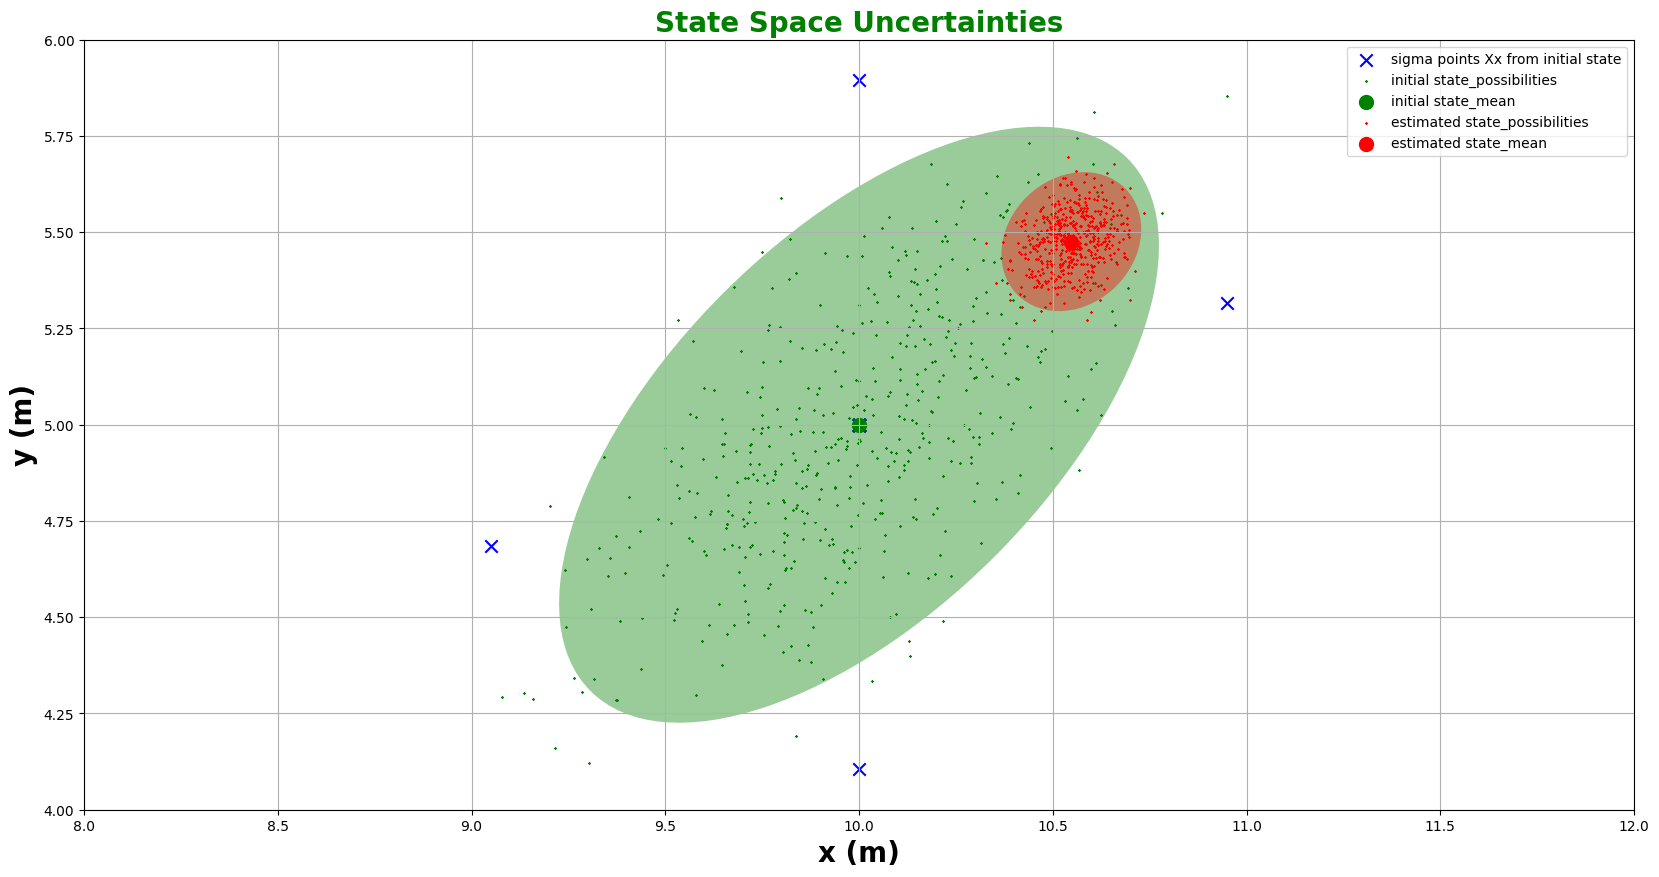

In [40]:
viewer = create_viewer('State Space Uncertainties', 'x (m)', 'y (m)', xlim=(8,12), ylim=(4,6))

print(x_sigmas[:2, :5])

sigma_xlist = x_sigmas[0, :]
sigma_ylist = x_sigmas[1, :]

viewer.scatter(sigma_xlist, sigma_ylist, s=80, marker='x', c='blue', label='sigma points Xx from initial state')

visualize_estimate(viewer, 'initial state', 'g', x0, P0)
visualize_estimate(viewer, 'estimated state', 'r', x, P)

update_plotter()

#### Simulating Trajectory

[10. 11. 12. 13. 14. 15. 16.]
[5.  5.  5.  6.  6.5 7.  7. ]
P_a = 
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.05 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.05 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.1  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.1  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.1 ]]

[[ 9.99002177 10.75347232 11.81870595 12.93576413 13.97255265 14.98551715
  15.9963238 ]
 [ 4.9949255   5.02034824  5.01847395  5.77733437  6.43401214  6.99288321
   7.10338182]
 [-0.00399129  0.43438163  0.79280882  0.97496393  1.00964375  1.01150534
   1.01105322]
 [-0.0020298   0.01374782  0.0050214   0.42807368  0.55614893  0.55767492
   0.30702938]]


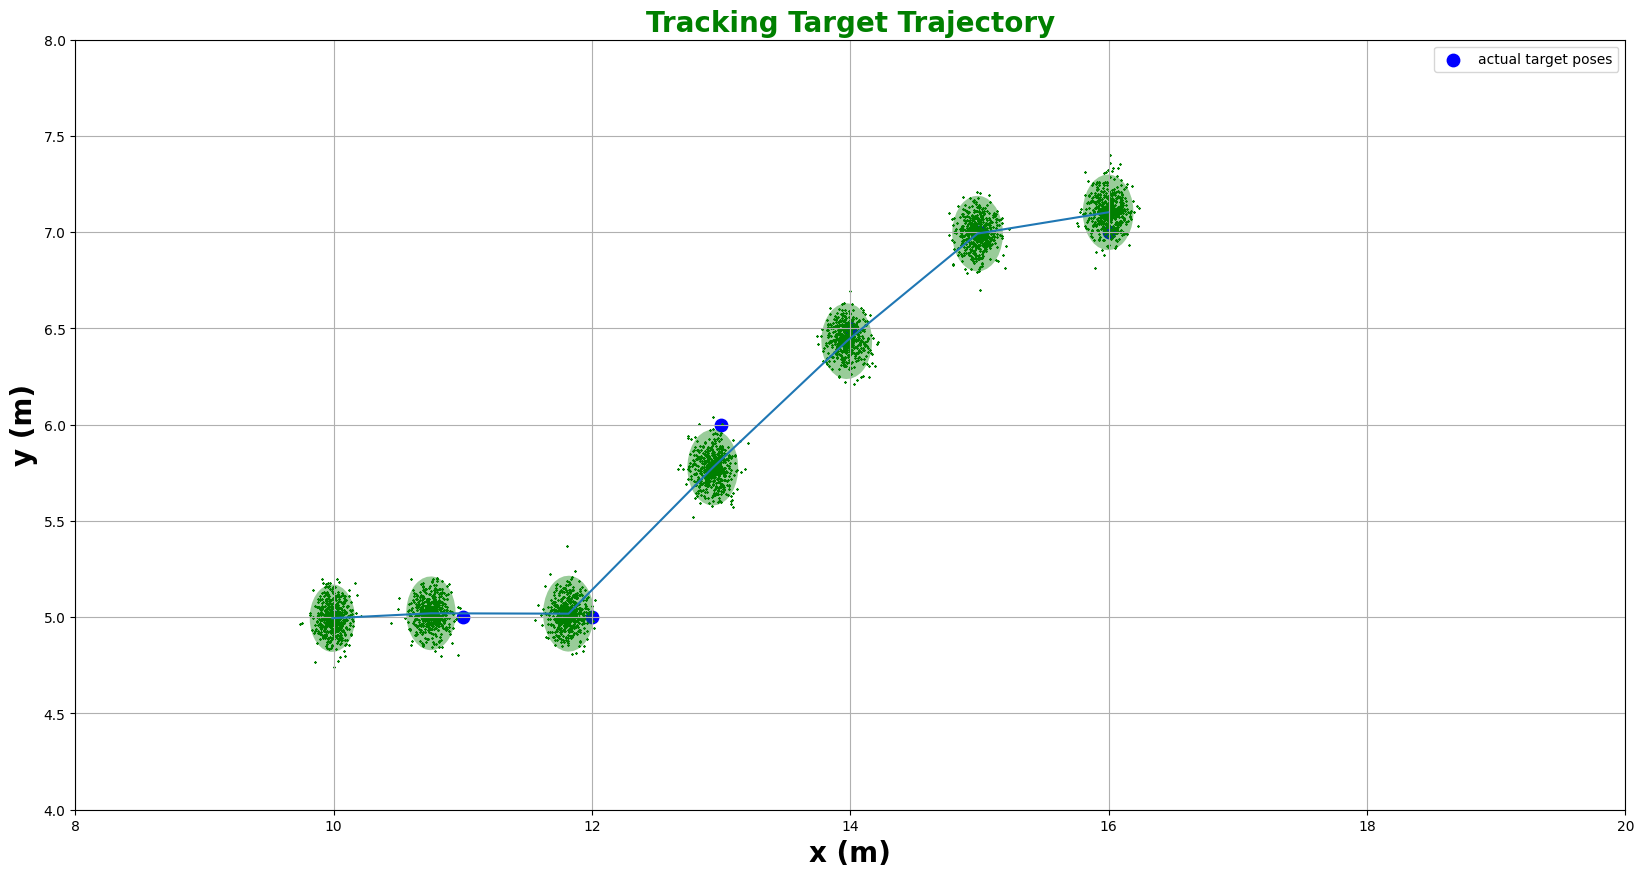

In [41]:
# generate trajectory

trajectory = [[10.0, 5.0], [11.0, 5.0], [12.0, 5.0], [13.0, 6.0], [14.0, 6.5], [15.0, 7.0], [16.0, 7.0]]
trajectory = np.asarray(trajectory)

traj_xlist = trajectory[:, 0]
traj_ylist = trajectory[:, 1]

print(traj_xlist)
print(traj_ylist)

measurements = []
for pose in trajectory:
    meas = RangeMeasurement(pose)
    measurements.append(meas.asArray())

measurements = np.asarray(measurements)



x0 = np.array([10., 5., 0., 0.])

P0 = np.array([[0.1, 0.0, 0.0, 0.0],
              [0.0, 0.1, 0.0, 0.0],
              [0.0, 0.0, 0.1, 0.0],
              [0.0, 0.0, 0.0, 0.1]])

Q = np.array([[0.05, 0.0, 0.0, 0.0],
              [0.0, 0.05, 0.0, 0.0],
              [0.0, 0.0, 0.1, 0.0],
              [0.0, 0.0, 0.0, 0.1]])

R = np.array([[0.1, 0.0],[0.0, 0.1]])

nx = np.shape(x0)[0]
nz = np.shape(R)[0]
nv = np.shape(x0)[0]
nn = np.shape(R)[0]

ukf = UKF(dim_x=nx, dim_z=nz, Q=Q, R=R, kappa=(3 - nx))

viewer = create_viewer('Tracking Target Trajectory', 'x (m)', 'y (m)', xlim=(8,20), ylim=(4,8))
viewer.scatter(traj_xlist, traj_ylist, s=80, marker='o', c='blue', label='actual target poses')

x, P = x0, P0

estimates = []

for iteration, z in enumerate(measurements):
    x, P, _ = ukf.predict(f_2, x, P)
    x, P, _ = ukf.correct(h_2, x, P, z)
    visualize_estimate(viewer, f'', 'g', x, P)
    
    estimates.append(x)

estimates = np.asarray(estimates).T
print(estimates)

estimates_px = estimates[0, :]
estimates_py = estimates[1, :]

estimates_vx = estimates[2, :]
estimates_vy = estimates[3, :]

viewer.plot(estimates_px, estimates_py)

update_plotter()